# Two-photon Functional Preprocessing (L395_f10)

In [1]:
from pathlib import Path
import logging

from social_imaging_scripts.metadata.loader import load_animals
from social_imaging_scripts.preprocessing.two_photon import functional, motion
from social_imaging_scripts.metadata.config import load_project_config
from social_imaging_scripts.metadata.config import resolve_raw_path


logging.basicConfig(level=logging.INFO, format="%(asctime)s %(levelname)s %(message)s")

In [2]:
cfg = load_project_config()
PROJECT_ROOT = Path.cwd().parent
ANIMAL_ID = "L395_f10"
OUTPUT_BASE = cfg.output_base_dir  # resolves to /mnt/f/johannes/testoutput on WSL, D:/social_imaging_outputs on Windows

METADATA_BASE = PROJECT_ROOT / "metadata/animals"

FAST_DISK = OUTPUT_BASE  # Path('D:/pipelineTestOutput/temp_suite2p') if you want binaries elsewhere
OPS_PATH = Path("../suite2p_ops_may2025.npy")

In [3]:
REPROCESS = False # whether to re-run plane splitting if outputs already exist
MOTION_REPROCESS = False
FPS = 2.0  # Hz

ops_template = motion.load_global_ops(OPS_PATH)
ops_template['nonrigid'] = True

In [4]:
collection = load_animals(base_dir=METADATA_BASE)
animal = collection.by_id(ANIMAL_ID)

functional_sessions = [s for s in animal.sessions if s.session_type == "functional_stack"]
if not functional_sessions:
    raise RuntimeError(f"No functional sessions found for {ANIMAL_ID}")

session = functional_sessions[0]
settings = session.session_data.preprocessing_two_photon
if settings is None:
    raise RuntimeError("Two-photon preprocessing settings missing in metadata")

raw_dir = Path(session.session_data.raw_path)
output_root = OUTPUT_BASE / ANIMAL_ID / "02_reg" / "00_preprocessing" / "2p_functional"

print("Raw directory:", raw_dir)
print("Output root:", output_root)
print("Mode:", settings.mode)
print("Planes:", settings.n_planes)
print("Frames per plane:", settings.frames_per_plane)
print("Blocks:", settings.blocks)

Raw directory: 01_raw/2p/functional
Output root: /mnt/f/johannes/testoutput/L395_f10/02_reg/00_preprocessing/2p_functional
Mode: resonant
Planes: 5
Frames per plane: 3
Blocks: [2, 3]


In [5]:
def preprocess_functional_session(*, animal, session, settings, output_root, reprocess=False):
    output_root = Path(output_root)
    metadata_path = output_root / "01_individualPlanes" / f"{animal.animal_id}_preprocessing_metadata.json"

    if metadata_path.exists() and not reprocess:
        print(f"Skipping preprocessing for {animal.animal_id} (metadata exists at {metadata_path})")
        return {"metadata": metadata_path}

    results = functional.run(
        animal_id=animal.animal_id,
        session_id=session.session_id,
        raw_dir=resolve_raw_path(Path(animal.root_dir) / session.session_data.raw_path),
        output_root=output_root,
        settings=settings,
    )
    print("Generated artefacts:")
    for key, path in results.items():
        print(f"  {key}: {path}")
    return results

In [6]:
results = preprocess_functional_session(
    animal=animal,
    session=session,
    settings=settings,
    output_root=output_root,
    reprocess=REPROCESS,
)

Skipping preprocessing for L395_f10 (metadata exists at /mnt/f/johannes/testoutput/L395_f10/02_reg/00_preprocessing/2p_functional/01_individualPlanes/L395_f10_preprocessing_metadata.json)


In [7]:
plane_dir = output_root / '01_individualPlanes'
plane_tiffs = sorted(plane_dir.glob(f'{ANIMAL_ID}_plane*.tif'))
if not plane_tiffs:
    raise FileNotFoundError(f'No plane TIFFs found in {plane_dir}')

motion_results = []
for plane_path in plane_tiffs:
    try:
        plane_idx = int(plane_path.stem.split('plane')[-1])
    except ValueError as err:
        raise ValueError(f'Unexpected plane filename: {plane_path.name}') from err

    res = motion.run_motion_correction(
        animal=animal,
        plane_idx=plane_idx,
        plane_tiff=plane_path,
        ops_template=ops_template,
        fps=FPS,
        output_root=output_root,
        fast_disk=FAST_DISK,
        reprocess=MOTION_REPROCESS,
    )
    motion_results.append(res)
    print(f'Processed plane {plane_idx}')

2025-10-03 10:31:05,770 INFO Skipping plane 0 (metadata exists at /mnt/f/johannes/testoutput/L395_f10/02_reg/00_preprocessing/2p_functional/02_motionCorrected/plane0/motion_metadata.json)
2025-10-03 10:31:05,780 INFO Skipping plane 1 (metadata exists at /mnt/f/johannes/testoutput/L395_f10/02_reg/00_preprocessing/2p_functional/02_motionCorrected/plane1/motion_metadata.json)
2025-10-03 10:31:05,789 INFO Skipping plane 2 (metadata exists at /mnt/f/johannes/testoutput/L395_f10/02_reg/00_preprocessing/2p_functional/02_motionCorrected/plane2/motion_metadata.json)
2025-10-03 10:31:05,797 INFO Skipping plane 3 (metadata exists at /mnt/f/johannes/testoutput/L395_f10/02_reg/00_preprocessing/2p_functional/02_motionCorrected/plane3/motion_metadata.json)


2025-10-03 10:31:05,808 INFO Skipping plane 4 (metadata exists at /mnt/f/johannes/testoutput/L395_f10/02_reg/00_preprocessing/2p_functional/02_motionCorrected/plane4/motion_metadata.json)


Processed plane 0
Processed plane 1
Processed plane 2
Processed plane 3
Processed plane 4


In [8]:
print('Motion correction outputs:')
for res in motion_results:
    for key, path in res.items():
        print(f'  {key}: {path}')

Motion correction outputs:
  metadata: /mnt/f/johannes/testoutput/L395_f10/02_reg/00_preprocessing/2p_functional/02_motionCorrected/plane0/motion_metadata.json
  metadata: /mnt/f/johannes/testoutput/L395_f10/02_reg/00_preprocessing/2p_functional/02_motionCorrected/plane1/motion_metadata.json
  metadata: /mnt/f/johannes/testoutput/L395_f10/02_reg/00_preprocessing/2p_functional/02_motionCorrected/plane2/motion_metadata.json
  metadata: /mnt/f/johannes/testoutput/L395_f10/02_reg/00_preprocessing/2p_functional/02_motionCorrected/plane3/motion_metadata.json
  metadata: /mnt/f/johannes/testoutput/L395_f10/02_reg/00_preprocessing/2p_functional/02_motionCorrected/plane4/motion_metadata.json


In [9]:
from itertools import islice

plane_dir = output_root / "01_individualPlanes"
if plane_dir.exists():
    print("Sample outputs:")
    for path in islice(sorted(plane_dir.glob("*.tif")), 5):
        print("  ", path)
    metadata_file = plane_dir / f"{animal.animal_id}_preprocessing_metadata.json"
    if metadata_file.exists():
        print("Metadata:", metadata_file)

Sample outputs:
   /mnt/f/johannes/testoutput/L395_f10/02_reg/00_preprocessing/2p_functional/01_individualPlanes/L395_f10_plane0.tif
   /mnt/f/johannes/testoutput/L395_f10/02_reg/00_preprocessing/2p_functional/01_individualPlanes/L395_f10_plane1.tif
   /mnt/f/johannes/testoutput/L395_f10/02_reg/00_preprocessing/2p_functional/01_individualPlanes/L395_f10_plane2.tif
   /mnt/f/johannes/testoutput/L395_f10/02_reg/00_preprocessing/2p_functional/01_individualPlanes/L395_f10_plane3.tif
   /mnt/f/johannes/testoutput/L395_f10/02_reg/00_preprocessing/2p_functional/01_individualPlanes/L395_f10_plane4.tif
Metadata: /mnt/f/johannes/testoutput/L395_f10/02_reg/00_preprocessing/2p_functional/01_individualPlanes/L395_f10_preprocessing_metadata.json


## FireANTs anatomy registration

In [10]:
from pathlib import Path

from social_imaging_scripts.registration import (
    FireANTsRegistrationConfig,
    register_two_photon_anatomy,
)
from social_imaging_scripts.metadata.config import resolve_raw_path, resolve_output_path

FIREANTS_CONFIG = FireANTsRegistrationConfig()
print(FIREANTS_CONFIG)

FireANTsRegistrationConfig(device='cuda', winsorize=WinsorizeSettings(enabled=True, lower_percentile=1.0, upper_percentile=99.0), affine=AffineSettings(scales=(12, 8, 4, 2, 1), iterations=(200, 200, 200, 100, 50), optimizer='Adam', optimizer_lr=0.003, cc_kernel_size=31, tolerance=1e-06, max_tolerance_iters=10, loss_type='fusedcc', extra_args={}), greedy=GreedySettings(enabled=True, scales=(12, 8, 4, 2, 1), iterations=(200, 200, 200, 100, 25), optimizer='Adam', optimizer_lr=0.5, cc_kernel_size=31, loss_type='fusedcc', smooth_grad_sigma=5.0, smooth_warp_sigma=3.0, deformation_type='compositive', optimizer_params={}, loss_params={}, extra_args={}), qc_middle_plane=None, qc_figsize=(10, 6))


In [11]:
anatomy_sessions = [
    s
    for s in animal.sessions
    if s.session_type == "anatomy_stack"
    and getattr(s.session_data, "stack_type", "") == "two_photon"
]
if not anatomy_sessions:
    raise RuntimeError(f"No two-photon anatomy session found for {ANIMAL_ID}")

anatomy_session = anatomy_sessions[0]

raw_anatomy_full = resolve_raw_path(Path(animal.root_dir) / anatomy_session.session_data.raw_path, cfg=cfg)
reference_path = resolve_raw_path(Path("03_Common_Use/reference brains/ref_05_LB_Perrino_2p/average_2p_noRot_orig.nrrd"), cfg=cfg)

if not raw_anatomy_full.exists():
    raise FileNotFoundError(raw_anatomy_full)
if not reference_path.exists():
    raise FileNotFoundError(reference_path)

registration_output_root = resolve_output_path(
    ANIMAL_ID,
    "02_reg",
    "02_fireants",
    cfg=cfg,
)
registration_output_root.mkdir(parents=True, exist_ok=True)

print("Moving stack:", raw_anatomy_full)
print("Reference brain:", reference_path)
print("Output root:", registration_output_root)


Moving stack: /mnt/nas_jlarsch/johannes/testIn/L395_f10_anatomy_00002_8b.nrrd
Reference brain: /mnt/nas_jlarsch/johannes/testIn/average_2p_noRot_flip_8b.nrrd
Output root: /mnt/f/johannes/testoutput/L395_f10/02_reg/02_fireants


In [12]:
fireants_results = register_two_photon_anatomy(
    animal_id=ANIMAL_ID,
    session_id=anatomy_session.session_id,
    stack_path=raw_anatomy_full,
    reference_path=reference_path,
    output_root=registration_output_root,
    animal_metadata=animal,
    session_metadata=anatomy_session,
    config=FIREANTS_CONFIG,
)

print("FireANTs outputs:")
for key, value in fireants_results.items():
    print(f"  {key}: {value}")

2025-10-03 10:31:12,952 INFO Using FFO: True
2025-10-03 10:31:12,964 INFO fireants_registration_start


USE_FFO: True
FFO_AVAILABLE: True
Using FFO: True


2025-10-03 10:31:20,271 INFO Setting iterations for loss function
2025-10-03 10:31:20,273 INFO Setting scales for loss function
2025-10-03 10:31:20,273 INFO Registration of type AffineRegistration initialized with dtype torch.float32
scale: 1, iter: 22/50, loss: -0.095487:  46%|████▌     | 23/50 [00:08<00:09,  2.85it/s]
2025-10-03 10:31:31,088 INFO Saved transform to /mnt/f/johannes/testoutput/L395_f10/02_reg/02_fireants/transforms/L395_f10_fireants_affine.mat
2025-10-03 10:31:31,091 INFO Setting iterations for loss function
2025-10-03 10:31:31,092 INFO Setting scales for loss function
2025-10-03 10:31:31,095 INFO Registration of type GreedyRegistration initialized with dtype torch.float32
scale: 1, iter: 24/25, loss: -0.119306: 100%|██████████| 25/25 [00:23<00:00,  1.08it/s]
2025-10-03 10:32:22,307 INFO Registration of type GreedyRegistration initialized with dtype torch.float32
scale: 1, iter: 49/50, loss: 0.000000: 100%|██████████| 50/50 [00:13<00:00,  3.79it/s]
2025-10-03 10:33:09,

FireANTs outputs:
  warped_stack: /mnt/f/johannes/testoutput/L395_f10/02_reg/02_fireants/L395_f10_anatomy_warped_fireants.tif
  affine_transform: /mnt/f/johannes/testoutput/L395_f10/02_reg/02_fireants/transforms/L395_f10_fireants_affine.mat
  metadata: /mnt/f/johannes/testoutput/L395_f10/02_reg/02_fireants/fireants_registration_metadata.json
  qc: /mnt/f/johannes/testoutput/L395_f10/02_reg/02_fireants/qc/L395_f10_fireants_qc.png
  greedy_transform: /mnt/f/johannes/testoutput/L395_f10/02_reg/02_fireants/transforms/L395_f10_fireants_greedy_warp.nii.gz
  greedy_inverse_transform: /mnt/f/johannes/testoutput/L395_f10/02_reg/02_fireants/transforms/L395_f10_fireants_greedy_inverse_warp.nii.gz


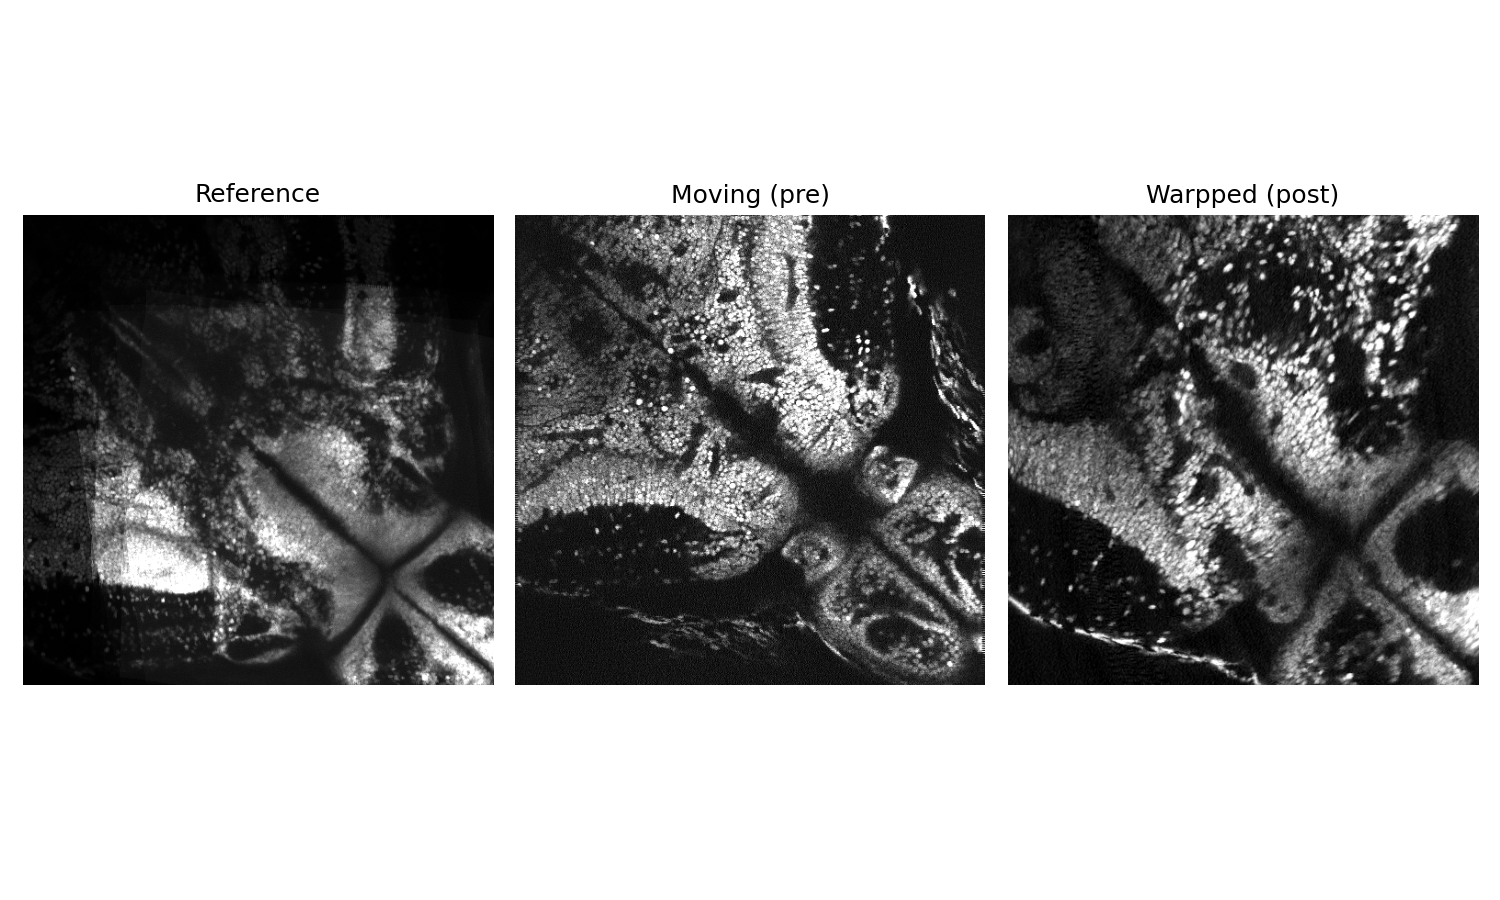

In [13]:
from IPython.display import display, Image

qc_path = fireants_results.get("qc")
if qc_path and Path(qc_path).exists():
    display(Image(filename=qc_path))
else:
    print("QC file not found")

In [ ]:
from IPython.display import display, Image

qc_path = fireants_results.get("qc")
if qc_path and Path(qc_path).exists():
    display(Image(filename=qc_path))
else:
    print("QC file not found")